In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import math

import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_size = 32

In [3]:
# helper to count net parameters from here: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# hard-coded for Conv2D defaults
def computeNewSize(size_init, stride, ks, padding):
    # uses formula here: https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d
    # we lose the kernel size on each side
    size = size_init - (ks - 1) + 2*padding
    # lose stuff due to stride
    size = 1 + (size - 1) / stride
    # always return an int
    return math.floor(size)

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, im_size, input_channels, encoded_dim):
        # call torch constructor
        super(Encoder, self).__init__()
        
        # stride convolutions to cut down size
        stride = 2
        
        # kernel size for filters
        ks = 3
        
        # how many channels for each conv dimension
        d1 = input_channels
        # how big is image before first conv?
        # only do one dimension and assume square
        i1 = im_size
        
        # padding to use on each dimension, keep image size nice
        p1 = 1
        p2 = 1
        
        # double channels as we go down
        d2 = d1 * 2
        d3 = d2 * 2
        
        # determine image size after convolutions
        i2 = computeNewSize(i1, stride, ks, p1)
        i3 = computeNewSize(i2, stride, ks, p2)
        
        print(f"i vals are {i1}, {i2}, {i3}")
        
        # what is the initial image size?
        self.im_size = im_size
        # do one strided convolution 
        self.conv1 = torch.nn.Conv2d(in_channels=d1, out_channels=d2, kernel_size=ks, stride=stride, padding_mode = "zeros", padding = p1)
        # use a relu activation
        self.act1 = torch.nn.ReLU()
        
        # another convolution and activation
        self.conv2 = torch.nn.Conv2d(in_channels=d2, out_channels=d3, kernel_size=ks, stride=stride, padding_mode = "zeros", padding = p1)
        self.act2 = torch.nn.ReLU()
        
        # now do a single fc layer (flatten in forward())
        d3_size_flat = d3 * i3 * i3

        # put a 3 in the name since it's the 3rd layer
        self.fc3 = torch.nn.Linear(in_features=d3_size_flat, out_features=encoded_dim)
        self.act3 = torch.nn.ReLU()
        
    def forward(self, x):
        # first convolution
        x = self.conv1(x)
        x = self.act1(x)
            
        # second convolution
        x = self.conv2(x)
        x = self.act2(x)
        
        # flatten last dims for FC layer
        x = x.flatten(start_dim=1)
            
        x = self.fc3(x)
        x = self.act3(x)
        
        # now x is encoded image
        return x
    
# opposite of encoder, do everything backwards
class Decoder(torch.nn.Module):
    def __init__(self, im_size, encoded_dim, output_channels):
        # call torch constructor
        super(Decoder, self).__init__()
        
        # stride convolutions to cut down size
        stride = 2
        
        # kernel size for filters
        ks = 3
        
        # how many channels for each conv dimension
        d3 = output_channels
        # after last upsample image should be original size
        i3 = im_size
        
        # start with more channels (or double going backwards)
        d2 = d3 * 2
        self.d1 = d1 = d2 * 2
        
        # padding to use on each dimension, keep image size nice
        p1 = 1
        p2 = 1
        
        # NOTE: this is tricky, because we used a stride we have to use output padding on upsamples to get right result
        # more info here: https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html
        op = 1
        
        # determine image size before upsamplings
        i2 = computeNewSize(i3, stride, ks, p1)
        self.i1 = i1 = computeNewSize(i2, stride, ks, p2)
        
        d1_size_flat = d1 * i1 * i1
        
        # undo FC layer
        self.fc1 = torch.nn.Linear(in_features=encoded_dim, out_features=d1_size_flat)
        self.act1 = torch.nn.ReLU()
        
        # do first upsample
        self.convT2 = torch.nn.ConvTranspose2d(in_channels=d1, out_channels=d2, kernel_size=ks, stride=stride, padding_mode = "zeros", padding = p1, output_padding=op)
        self.act2 = torch.nn.ReLU()
        
        # Second upsample should output image
        self.convT3 = torch.nn.ConvTranspose2d(in_channels=d2, out_channels=d3, kernel_size=ks, stride=stride, padding_mode = "zeros", padding = p1, output_padding=op)
        # skip activation since we don't want to constrain output
        # self.act2 = torch.nn.ReLU()
        
        
        
    def forward(self, x):
        # first convolution
        x = self.fc1(x)
        x = self.act1(x)
        
        # reshape x to make last dimension into 2
        xs = x.shape
                
        # maintain batch size and channels
        x = x.reshape(xs[0], self.d1, self.i1, self.i1)
                            
        # second convolution
        x = self.convT2(x)
        x = self.act2(x)
                
        x = self.convT3(x)
        #x = self.act3(x)
                
        # now x is decoded image, should match original
        return x
    


In [5]:
# autoencoder class that combines the two
class Autoencoder(torch.nn.Module):
    def __init__(self, im_size, encoded_dim, image_channels):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(im_size=im_size, encoded_dim=encoded_dim, input_channels=image_channels)
        self.decoder = Decoder(im_size=im_size, encoded_dim=encoded_dim, output_channels=image_channels)
        
    def forward(self, x):
        # encode phase
        x = self.encoder(x)
        
        # decode phase
        x = self.decoder(x)
        
        return x
        

In [6]:
train_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(model, loss_func, optimizer, train_loader):
    model = model.train()
    for e in range(train_epochs):
        running_loss = 0
        for batch, _ in train_loader:
            # zero out loss
            optimizer.zero_grad()

            # run AE
            y = model(batch)

            # compute loss
            loss = loss_func(y, batch)

            # get gradients
            loss.backward()

            # update net
            optimizer.step()

            # compute running loss
            running_loss += loss.item()
        
        print(f"Training epoch {e}, running loss is {running_loss}")
        

In [7]:
# boilerplate loading code from here
# https://gist.github.com/AFAgarap/3129def5ac7f8471f5429768bfa01ae0/
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=2
)

# cifar classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


In [14]:
im_size = 32 # for CIFAR10
edim = 40
im_channels = 3 #full color

model = Autoencoder(im_size=im_size, encoded_dim = edim, image_channels=im_channels)

# run on GPU if we can
model = model.to(device)

encoder_model = model.encoder
decoder_model = model.decoder

# use L2 error
loss_func = torch.nn.MSELoss()
# adam optimizer
optimizer = torch.optim.Adam(model.parameters())

num_params = count_parameters(model)

print(f"Model architecture: {model}")
print(f"Model has {num_params} parameters!")

i vals are 32, 16, 8
Model architecture: Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act1): ReLU()
    (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act2): ReLU()
    (fc3): Linear(in_features=768, out_features=40, bias=True)
    (act3): ReLU()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=40, out_features=768, bias=True)
    (act1): ReLU()
    (convT2): ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (act2): ReLU()
    (convT3): ConvTranspose2d(6, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)
Model has 63895 parameters!


In [15]:
train(model, loss_func, optimizer, train_loader)

Training epoch 0, running loss is 142.5855429545045
Training epoch 1, running loss is 117.69665058236569
Training epoch 2, running loss is 105.95334486896172
Training epoch 3, running loss is 103.6986481314525
Training epoch 4, running loss is 101.61936853267252


torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])


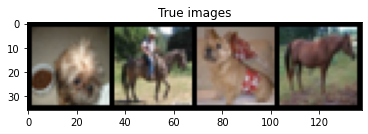

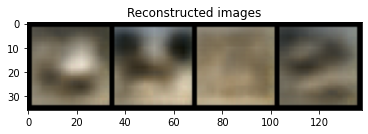

In [16]:

def plot_image(im, title=None):
    fig = plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()
    return fig

# taken from here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()


images = images[:4].detach()

images_autoencoded = model(images).detach()


print(images.shape)
print(images_autoencoded.shape)

# show images
fig = plot_image(torchvision.utils.make_grid(images), title="True images")

fig = plot_image(torchvision.utils.make_grid(images_autoencoded), title="Reconstructed images")

plt.show()

# print labels


In [17]:
dataiter = iter(train_loader)

data, labels = dataiter.next()
data_encoded = model.encoder(data)

In [18]:
from sklearn.svm import SVC

# use a subset of the training set (only to demonstrate how to do it)
train_iter = iter(train_loader)

train_data, train_labels = train_iter.next()
train_data_encoded = model.encoder(train_data)

X_train = train_data_encoded.detach().numpy()
y_train = train_labels.detach().numpy()


# fit a simple SVM, this probably won't work well
reg_model = SVC(kernel="linear", C=0.025).fit(X_train, y_train)

In [19]:
# now do the same on the test set
test_iter = iter(test_loader)

test_data, test_labels = test_iter.next()
test_data_encoded = model.encoder(test_data)

X_test = test_data_encoded.detach().numpy()
y_test = labels.detach().numpy()

y_pred = reg_model.predict(X_test)

print(f"actual is {y_test}, predicted is {y_pred}")

# how did it do?
score = np.sum(y_test == y_pred) / y_pred.size

# yikes
print(f"Score is {score}")

actual is [9 9 1 4 0 7 7 1], predicted is [1 1 1 1 1 1 1 1]
Score is 0.25
